In [2]:
from discretizer import discretizer
from client import client
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
from server import server_twosample_U, server_twosample_chi
from data_generator import data_generator
import time

In [31]:
m = torch.distributions.bernoulli.Bernoulli(torch.tensor([0.3]))
m.sample((2,5)).view(2,5)

tensor([[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])

In [3]:
gen = data_generator(device)

In [51]:
p, p_priv = gen._generate_power_law_p_private(10,2.1, 0.5)

<BarContainer object of 10 artists>

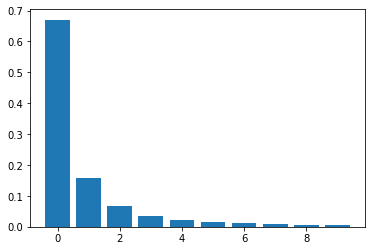

In [52]:
plt.bar(range(10), p.cpu())

<BarContainer object of 10 artists>

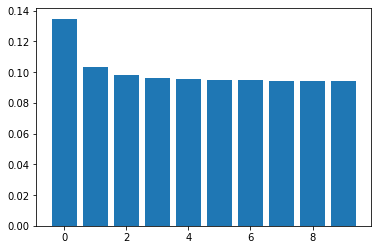

In [53]:
plt.bar(range(10), p_priv.cpu())

In [2]:
t = time.time()

server_now = server_twosample_U(device)
data_gen = data_generator(device)
alphabet_size = 1000
beta = 0.5
privacy_level = 1
n_test = 1
n_permutation = 99
significance_level = 0.05
sample_size = 100000
test_result = torch.zeros(n_test).to(device)
for i in range(n_test):
    data_y = data_gen.generate_nearly_unif(alphabet_size, beta, sample_size = sample_size)
    data_z = data_gen.generate_nearly_unif(alphabet_size, beta, sample_size = sample_size)
    LDPclient = client(device)
    LDPclient.load_data_disc(data_y, data_z, alphabet_size)
    data_y_priv, data_z_priv = LDPclient.release_LapU(privacy_level)
    test_result[i] = server_now.release_p_value(data_y_priv, data_z_priv, n_permutation)
    
    
elapsed = time.time() - t
elapsed

16.566758632659912

In [9]:
(data_y==0).sum()

tensor(1621, device='cuda:0')

In [15]:
torch.tensor([1,2,4]).bincount(minlength=6)

tensor([0, 1, 1, 0, 1, 0])

In [25]:
t = time.time()

server_now = server_twosample_chi(device)
data_gen = data_generator(device)
alphabet_size = 3000
beta = 2.5
privacy_level = 0.01
n_test = 100
sample_size = 10000
test_result = torch.zeros(n_test).to(device)
for i in range(n_test):
    data_y = data_gen.generate_nearly_unif(alphabet_size, beta, sample_size = sample_size)
    data_z = data_gen.generate_nearly_unif(alphabet_size, beta, sample_size = sample_size)
    LDPclient = client(device)
    LDPclient.load_data_disc(data_y, data_z, alphabet_size)
    data_y_priv, data_z_priv = LDPclient.release_genRR(privacy_level)
    test_result[i] = server_now.release_p_value(data_y_priv, data_z_priv, alphabet_size)
    
    
elapsed = time.time() - t
elapsed

131.28636121749878

In [24]:
(test_result < 0.7).sum()/n_test 

tensor(0.7100, device='cuda:0')

In [6]:
data_y_priv.dtype

torch.int64

# testing the discretizer

In [3]:
data_conti = torch.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0.6],
    [0, 0, 0.6, 0],
    [0, 0, 0.6, 0.6],
    [0, 0.6, 0, 0],
    [0, 0.6, 0, 0.6],
    [0, 0.6, 0.6, 0],
    [0, 0.6, 0.6, 0.6],   
    [0.6, 0, 0, 0],
    [0.6, 0, 0, 0.6],
    [0.6, 0, 0.6, 0],
    [0.6, 0, 0.6, 0.6],
    [0.6, 0.6, 0, 0],
    [0.6, 0.6, 0, 0.6],
    [0.6, 0.6, 0.6, 0],
    [0.6, 0.6, 0.6, 0.6],
])
dsc = discretizer(device)
data_disc, n_category = dsc.transform(data_conti, 2)
data_disc

LDPclient = client(device)
LDPclient.load_data_disc(data_disc, data_disc, n_category)

# testing the LapU for discrete data

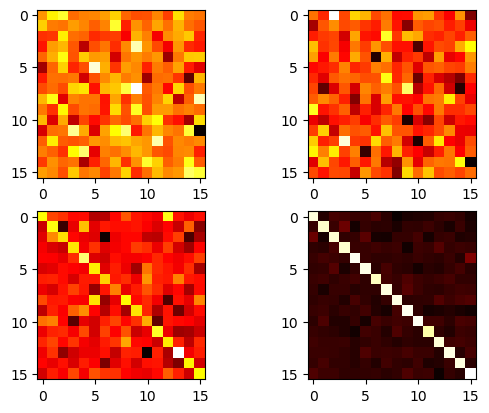

In [6]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(LDPclient.release_LapU(0.5)[1], cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(LDPclient.release_LapU(1)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(LDPclient.release_LapU(10)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(LDPclient.release_LapU(100)[1], cmap = 'hot', interpolation = 'nearest')

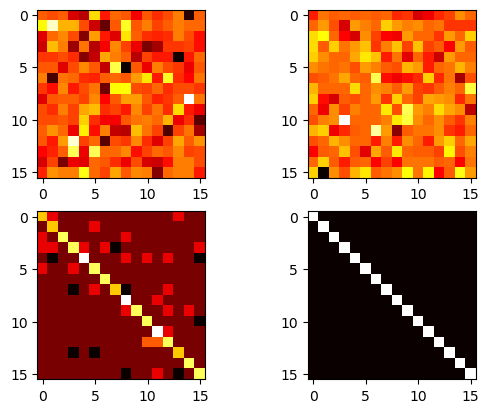

In [7]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(LDPclient.release_DiscLapU(0.5)[1], cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(LDPclient.release_DiscLapU(1)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(LDPclient.release_DiscLapU(10)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(LDPclient.release_DiscLapU(100)[1], cmap = 'hot', interpolation = 'nearest')

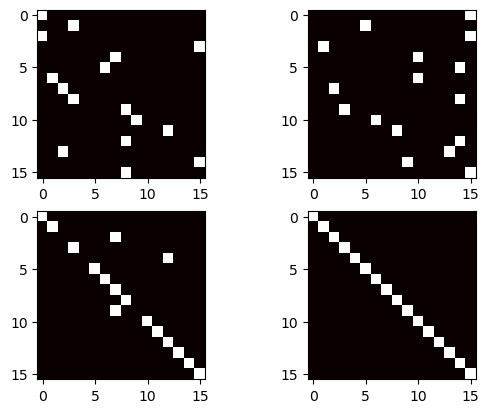

In [8]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(LDPclient.release_genRR(0.5)[1], cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(LDPclient.release_genRR(1)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(LDPclient.release_genRR(5)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(LDPclient.release_genRR(10)[1], cmap = 'hot', interpolation = 'nearest')

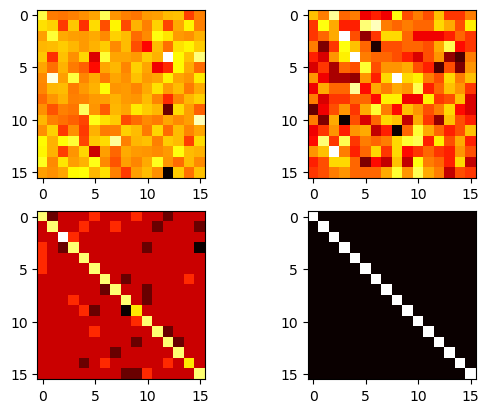

In [9]:
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(LDPclient.release_DiscLapU(0.5)[1], cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(LDPclient.release_DiscLapU(1)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(LDPclient.release_DiscLapU(10)[1], cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(LDPclient.release_DiscLapU(100)[1], cmap = 'hot', interpolation = 'nearest')



In [13]:
from abc import ABCMeta, abstractmethod
class server(client):
    def release_p_value(self, data_y, data_z, n_permutation):
        self._permutation_test(data_y, data_z, n_permutation)

    def _permutation_test(self, data_y, data_z, n_permutation):
        n_1 = self._get_sample_size(data_y)
        n_2 = self._get_sample_size(data_z) 
        n = n_1 + n_2
        tst_data_combined = torch.vstack((data_y, data_z))
       
        u_stat_original = self._calculate_statistic(data_y, data_z) #original statistic
        #print(f"original u-statistic:{u_stat_original}")
        
        #permutation procedure
        u_stat_permuted = torch.empty(n_permutation).to(self.cuda_device)
        
        for i in range(n_permutation):
            permutation = torch.randperm(n)
            perm_stat_now = self._calculate_statistic(
                tst_data_combined[permutation][:n_1,:],
                tst_data_combined[permutation][n_1:,:]
            ).to(self.cuda_device)
            u_stat_permuted[i] = perm_stat_now

               
        p_value_proxy = (1 +
                         torch.sum(
                             torch.gt(input = u_stat_permuted, other = u_stat_original)
                         )
                        ) / (n_permutation + 1)
      
        return(p_value_proxy)
    
    @abstractmethod   
    def _calculate_statistic(self, data_y, data_z):
        raise NotImplementedError()
    
def server_twosample_U(server):    
    def _calculate_statistic(self, data_y, data_z):
        n_1 = self._get_sample_size(data_y)
        n_2 = self._get_sample_size(data_z) 
    
        y_row_sum = torch.sum(data_y, axis = 0)
        z_row_sum = torch.sum(data_z, axis = 0)


        one_Phi_one = torch.inner(y_row_sum, y_row_sum)
        one_Psi_one = torch.inner(z_row_sum, z_row_sum)

        tr_Phi = torch.sum(torch.square(data_y))
        tr_Psi = torch.sum(torch.square(data_z))

        one_Phi_tilde_one = one_Phi_one - tr_Phi
        one_Psi_tilde_one = one_Psi_one - tr_Psi


        # y only part. log calculation in case of large n1
        sign_y = torch.sign(one_Phi_tilde_one)
        abs_u_y = torch.exp(torch.log(torch.abs(one_Phi_tilde_one)) - torch.log(n_1) - torch.log(n_1 - 1) )
        u_y = sign_y * abs_u_y


        # z only part. log calculation in case of large n2
        sign_z = torch.sign(one_Psi_tilde_one)

        abs_u_z = torch.exp(torch.log(torch.abs(one_Psi_tilde_one)) - torch.log(n_2) - torch.log(n_2 - 1) )
        u_z = sign_z * abs_u_z

        # cross part
        cross = torch.inner(y_row_sum, z_row_sum)
        sign_cross = torch.sign(cross)
        abs_cross = torch.exp(torch.log(torch.abs(cross)) +torch.log(torch.tensor(2))- torch.log(n_1) - torch.log(n_2) )
        u_cross = sign_cross * abs_cross

        return(u_y + u_z - u_cross)

tensor([0.1992, 0.1408, 0.1150, 0.0996, 0.0891, 0.0813, 0.0753, 0.0704, 0.0664,
        0.0630])
tensor([0.1992, 0.1408, 0.1150, 0.0996, 0.0891, 0.0813, 0.0753, 0.0704, 0.0664,
        0.0630])
